In [1]:
import numpy as np
import HARK
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline, InterpolatedUnivariateSpline
from matplotlib import pyplot as plt

In [2]:
def u(c, ρ):
  if ρ == 1:
    return np.log(c)
  elif ρ >= 0:
    return (c ** (1 - ρ)) / (1 - ρ)
  else:
    raise ValueError("σ must be non-negative")

In [3]:
# Determine parameters for solution

ρ, Γ, Rf, ℜ, β = 4, 1.03, 1.04, 1.10, 0.8

T = 50


# Shocks in the order η, ν, ζ

Σ = np.array(
    [
        [0.6, 0.3, 0.000001],
        [0.3, 0.8, 0.000001],
        [0.000001, 0.000001, 0.5]
    ]
)

μ = - np.diag(Σ) / 2

In [4]:
shocks = HARK.distribution.MVLogNormal(μ, Σ)

shocks_approx = shocks._approx_equiprobable(N = 10, tail_bound = [0.0015, 0.9985], endpoints = True)

worst = shocks_approx.atoms.min(axis=1)

In [5]:
def m(a, Rf, ℜ, κ, Γ, atom):
    η, ν, ζ = atom

    return (a * (Rf + κ * (ℜ * ν - Rf)) / (Γ * η)) + ζ

def κ_inv_euler(κ, a, c_next, Rf, ℜ, Γ, ρ, shocks_approx):

    def ℓ(atom):
        return m(a, Rf, ℜ, κ, Γ, atom)

    def g(atom):
        η, ν, ζ = atom
        
        return ((ℜ * ν) - Rf) * ((Γ * η * c_next(ℓ(atom))) ** (-ρ))

    return shocks_approx.expected(func = g)

def κ_hat(a, c_next, Rf, ℜ, Γ, ρ, shocks_approx):

    κ_func = lambda x : κ_inv_euler(x, a = a, c_next = c_next, Rf = Rf, ℜ = ℜ, Γ = Γ, ρ = ρ, shocks_approx = shocks_approx)

    κ = root_scalar(κ_func, method="newton", x0 = 0.3)['root']

    return κ

In [6]:
def c_hat(a, κ, c_next, Rf, ℜ, Γ, ρ, β, shocks_approx):

    def ℓ(atom):
        return m(a, Rf, ℜ, κ, Γ, atom)

    def c_rho(atom):
        η, ν, ζ = atom

        return (β * Rf * ((Γ * η * c_next(ℓ(atom))) ** (-ρ)))

    return (shocks_approx.expected(func = c_rho)) ** (-1/ρ)

In [7]:
def solve_finite_period_model(ρ, Γ, Rf, ℜ, β, μ, Σ, T, n = 20, boroConst : bool = False, N = 10, tail_bound = [0.0015, 0.9985], decomp="cholesky", interp="linear"):

    shocks = HARK.distribution.MVLogNormal(μ, Σ)

    shocks_discrete = shocks._approx_equiprobable(N = N, tail_bound = tail_bound, endpoints=False, decomp=decomp)

    worst = shocks_discrete.atoms.min(axis=1)

    ηMin, νMin, ζMin = worst

    aMin = (-ζMin) * Γ * ηMin / (ℜ * νMin)

    t = T - 1

    aLogGrid = np.linspace(-2, 2, n-1)

    aNrmDiffs = np.exp(aLogGrid)

    aNrmGrid = np.empty(n)

    if boroConst is True:
        aNrmGrid[0] = 0
        aNrmGrid[1:] = aNrmDiffs
    else:
        aNrmGrid[0] = aMin
        aNrmGrid[1:] = aNrmDiffs + aMin

    aNrmGrid = np.where(aNrmGrid == 0.0, 0.001, aNrmGrid)

    c_T = lambda x : x

    policies = [{'cFunc': c_T}]

    while t > 0:
        c_next = policies[T-(t+1)]['cFunc']

        κ_hat_vec = np.vectorize(lambda a : κ_hat(a, c_next, Rf, ℜ, Γ, ρ, shocks_discrete))

        κ_opt = κ_hat_vec(aNrmGrid)

        κGrid = np.where(κ_opt > 1, 1, np.where(κ_opt < 0, 0, κ_opt))

        def c_hat_opt(a, κ):
            return c_hat(a, κ, c_next, Rf, ℜ, Γ, ρ, β, shocks_discrete)

        c_hat_vec = np.vectorize(c_hat_opt)

        cNrm_opt = c_hat_vec(aNrmGrid, κGrid)

        cNrmGrid = np.where(cNrm_opt < 0, 0, cNrm_opt)

        mNrmGrid = cNrmGrid + aNrmGrid

        if boroConst is True:
            κvals = np.empty(n+1)
            κvals[0] = 0.0
            κvals[1:] = κGrid

            cvals = np.empty(n+1)
            cvals[0] = 0.0
            cvals[1:] = cNrmGrid

            mvals = np.zeros(n+1)
            mvals[1:] = mNrmGrid
        else:
            κvals = κGrid
            cvals = cNrmGrid
            mvals = aNrmGrid + cNrmGrid

        if interp=="linear":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=1)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)
        elif interp=="spline":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=3)
        elif interp=="SL":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)

        policy_t = {"cFunc":cFunc_t, "κFunc":κFunc_t, "mNrmGrid":mvals, "κGrid":κvals, "cNrmGrid":cvals}

        policies.append(policy_t)

        t -= 1

    policies.reverse()

    return policies

In [8]:
def solve_infinite_horizon_model(ρ, Γ, Rf, ℜ, β, μ, Σ, Cguess, n = 20, boroConst : bool = False, N = 10, tail_bound = [0.0015, 0.9985], decomp="cholesky", interp="linear", maxiter=100, tol=1e-6):
    shocks = HARK.distribution.MVLogNormal(μ, Σ)

    shocks_discrete = shocks._approx_equiprobable(N = N, tail_bound = tail_bound, endpoints=False, decomp=decomp)

    worst = shocks_discrete.atoms.min(axis=1)

    ηMin, νMin, ζMin = worst

    aMin = (-ζMin) * Γ * ηMin / (ℜ * νMin)

    aLogGrid = np.linspace(-2, 2, n-1)

    aNrmDiffs = np.exp(aLogGrid)

    aNrmGrid = np.empty(n)

    if boroConst is True:
        aNrmGrid[0] = 0
        aNrmGrid[1:] = aNrmDiffs
    else:
        aNrmGrid[0] = aMin
        aNrmGrid[1:] = aNrmDiffs + aMin

    aNrmGrid = np.where(aNrmGrid == 0.0, 0.001, aNrmGrid)

    c_T = Cguess

    policies = [{'cFunc': c_T}]

    iter = 0
    error = 100

    while (iter < maxiter) and (error > tol):
        c_prev = policies[-1]['cFunc']

        κ_hat_vec = np.vectorize(lambda a : κ_hat(a, c_prev, Rf, ℜ, Γ, ρ, shocks_discrete))

        κ_opt = κ_hat_vec(aNrmGrid)

        κGrid = np.where(κ_opt > 1, 1, np.where(κ_opt < 0, 0, κ_opt))

        def c_hat_opt(a, κ):
            return c_hat(a, κ, c_prev, Rf, ℜ, Γ, ρ, β, shocks_discrete)

        c_hat_vec = np.vectorize(c_hat_opt)

        cNrm_opt = c_hat_vec(aNrmGrid, κGrid)

        cNrmGrid = np.where(cNrm_opt < 0, 0, cNrm_opt)

        mNrmGrid = cNrmGrid + aNrmGrid

        if boroConst is True:
            κvals = np.empty(n+1)
            κvals[0] = 0.0
            κvals[1:] = κGrid

            cvals = np.empty(n+1)
            cvals[0] = 0.0
            cvals[1:] = cNrmGrid

            mvals = np.zeros(n+1)
            mvals[1:] = mNrmGrid
        else:
            κvals = κGrid
            cvals = cNrmGrid
            mvals = aNrmGrid + cNrmGrid

        if interp=="linear":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=1)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)
        elif interp=="spline":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=3)
        elif interp=="SL":
            cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
            κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)

        policy_t = {"cFunc":cFunc_t, "κFunc":κFunc_t, "mNrmGrid":mvals, "κGrid":κvals, "cNrmGrid":cvals}

        policies.append(policy_t)

        iter += 1

        if iter > 1:
            m_prev = policies[-2]['mNrmGrid']
            error = np.max(np.abs(mvals - m_prev))

    policies.reverse()

    return policies

In [18]:
solution = solve_finite_period_model(ρ=ρ, Γ=Γ, Rf=Rf, ℜ=ℜ, β=β, μ=μ, Σ=Σ, T=T, n = 20, boroConst=False, interp="SL")

In [24]:
solution2 = solve_infinite_horizon_model(ρ=ρ, Γ=Γ, Rf=Rf, ℜ=ℜ, β=β, μ=μ, Σ=Σ, Cguess=lambda x : 0.5 * x, n = 20, boroConst=False, interp="linear")

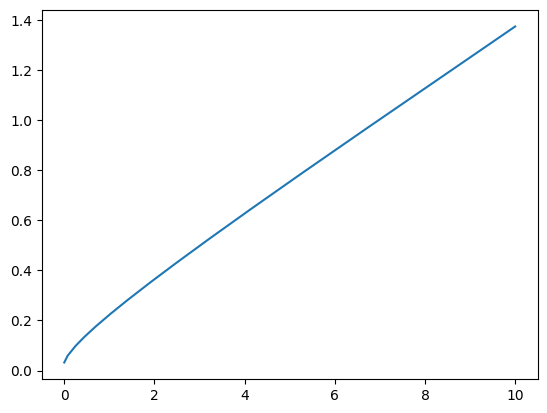

In [32]:
mGrid = np.linspace(0, 10, 400)

plt.plot(mGrid, solution2[0]['cFunc'](mGrid))

In [12]:
# plt.plot(mGrid, np.interp(mGrid, solution[48]['mNrmGrid'], solution[48]['cNrmGrid']))

In [13]:
# plt.plot(mGrid, np.interp(mGrid, solution[48]['mNrmGrid'], solution[48]['κGrid']))

In [14]:
# solution[48]['κGrid']